In [1]:
!pip install vrplib

In [2]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vrplib
from types import SimpleNamespace
import copy
from collections import deque

In [3]:
%matplotlib inline

# Genetic Algorithm summary

### Data

In [5]:
vrp_data = vrplib.read_instance("data/ORTEC-n405-k18.vrp.txt")
bks = SimpleNamespace(**vrplib.read_solution("data/ORTEC-n405-k18.sol.txt"))

### Plot solution

In [6]:
def plot_solution(solution, name="Best known solution"):
    try:
        r = solution.routes
        cost = solution.cost
    except AttributeError:
        r = solution
        cost = solution_cost(r)

    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = plt.cm.rainbow(np.linspace(0, 1, len(r)))

    for idx, route in enumerate(r):
        ax.plot(
            [vrp_data["node_coord"][loc][0] for loc in [0] + route + [0]],
            [vrp_data["node_coord"][loc][1] for loc in [0] + route + [0]],
            color=cmap[idx],
            marker=".",
        )

    # Plot the depot
    kwargs = dict(label="Depot", zorder=3, marker="*", s=750)
    ax.scatter(*vrp_data["node_coord"][0], c="tab:red", **kwargs)

    ax.set_title(f"{name}\n Total distance: {cost}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

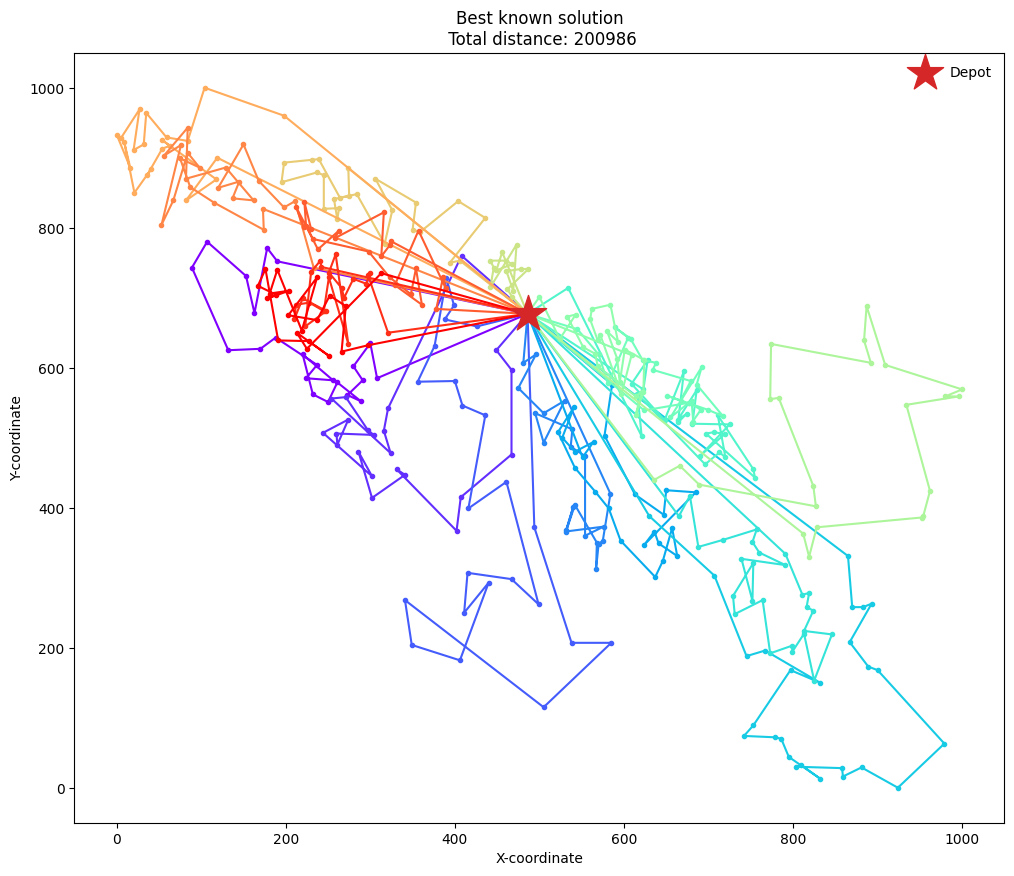

In [7]:
plot_solution(bks)

In [8]:
bks.cost

200986

In [9]:
def route_cost(tour, distances):
    full_route = [0] + tour + [0] # Add dc as starting and ending point

    return sum(
        distances[full_route[idx]][full_route[idx + 1]] for idx in range(len(full_route) - 1)
    )

class SolutionPermitation:

    def __init__(self, customers, dist_matrix, demand, max_capacity, penalty):
        self.customers = customers
        self.routes = self._route_creation(demand, max_capacity)
        self.cost = self._cost(dist_matrix)
        self.fitness = self._fitness(penalty)

    def _cost(self, dist_matrix):
        """
        Sumation of the cost of all individual routes
        """
        cost = 0
        for route in self.routes:
            cost += route_cost(route, dist_matrix)
        return cost


    def _fitness(self, penalty):
        """
        Calculate the fitness of the solution by calculating the penalty
        and adding it to the cost of the solution.
        """
        # ToDo: penalyse for number of routes to stimulate less routes
        return self.cost + penalty * len(self.routes)


    def _route_creation(self, demand, max_capacity):
        """
        Create routes by simple iteration over list of customers, and starting
        new route when capacity is reached.
        """
        routes = [[]]
        current_route_demand = 0
        for cust in self.customers:
            if current_route_demand + demand[cust] < max_capacity:
                routes[-1].append(cust)
                current_route_demand += demand[cust]
            else:
                routes.append([cust])
                current_route_demand = demand[cust]


        return routes

    def __gt__(self, cls):
        return self.fitness > cls.fitness

    def __repr__(self):
        return f"Solution cost: {self.cost}, fitness: {self.fitness}"

    def __iter__(self):
        return self



In [10]:
class GAVrp:

    def __init__(self, customers: int,
                 population_size: int,
                 demand,
                 distance_matrix,
                 customer_coords,
                 vehicle_max_capacity,
                 generations=600,
                 penalty=0.9,
                 crossover_rate=0.8,
                 mutation_rate=0.5,
                 remove_rate=0.4
                ):
        self.customers = list(range(1,customers))
        self.population_size = population_size
        self.demand = demand
        self.dist_matrix = distance_matrix
        self.customer_coords = customer_coords
        self.vehicle_max_capacity = vehicle_max_capacity
        self.penalty = penalty
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.remove_rate = remove_rate
        self.bks = None
        self.history = []

        self.population = self._init_population()

    def _init_population(self):
        """
        Create the initial population of solutions by randomly permutating the customers
        """
        populations = []
        for _ in range(self.population_size):
            perm = self.customers[:]
            random.shuffle(perm)
            populations.append(SolutionPermitation(perm, self.dist_matrix, self.demand, self.vehicle_max_capacity, self.penalty))

        return populations

    def _tournament_selection(self):
        """
        returns the best of twenty randomly selected solutions
        """
        candidate_solutions = np.random.choice(self.population, size=20)
        best_candidate = min(candidate_solutions, key=lambda c: c.fitness)
        self.population.remove(best_candidate)
        return best_candidate

    def _ox(self, p_one, p_two, i, j):
        """
        Order crossover between two solutions
        """
        child = [None] * len(p_one.customers)
        for el in range(i, j+1):
            child[el] = p_one.customers[el]
        fill = deque([x for x in p_two.customers if x not in child])
        for el in range(len(p_one.customers)):
            if child[el] is None:
                child[el] = fill.popleft()

        return SolutionPermitation(child, self.dist_matrix, self.demand, self.vehicle_max_capacity, self.penalty)

    def _crossover(self, parent_one, parent_two):
        """
        Choosing crossover method if random number is less than crossover rate
        """
        # ToDo: add uniform crossover
        if random.random() < self.crossover_rate:
            start_idx, end_idx = sorted(random.sample(range(len(self.customers)), 2))

            child_one = self._ox(parent_one, parent_two, start_idx, end_idx )
            child_two = self._ox(parent_two, parent_one, start_idx, end_idx )

            return child_one, child_two
        return parent_one, parent_two

    def _mutation(self, child):
        """
        Randomly preforming mutations on a child
        """
        if random.random() < self.mutation_rate:
            i, j = sorted(random.sample(range(self.population_size), 2))
            child.customers[i], child.customers[j] = child.customers[j], child.customers[i]

        if random.random() < 0.01:
            child = self._random_greedy_mutation(child)
        return child

    def _random_greedy_mutation(self, child):
        """
        Using nearest negibor on part of child solution
        """
        size_of_mutaion_sting = 200
        idx = random.sample(range(len(self.customers)), 1)[0]
        unvisited = child.customers[idx:idx+size_of_mutaion_sting]
        sub_route = [0]
        while unvisited:
            # Add the nearest unvisited customer to the route
            current = sub_route[-1]
            nearest = [nb for nb in self.neighbours_sorted_by_distance(current) if nb in unvisited][0]

            sub_route.append(nearest)
            unvisited.remove(nearest)

        customers = sub_route[1:]
        new_cust = []
        for i in range(len(self.customers)):
            if i < idx or i >= idx + size_of_mutaion_sting:
                new_cust.append(child.customers[i])
            else:
                new_cust.append(customers.pop())

        return SolutionPermitation(new_cust, self.dist_matrix, self.demand, self.vehicle_max_capacity, self.penalty)

    def neighbours_sorted_by_distance(self, cust):
        """
        Returns indexes in order of nearest to a customer
        """
        return np.argsort(self.dist_matrix[cust])[1:]

    def _remove_worse(self):
        """
        Remove worst solutions from populations
        """
        self.population.sort(key=lambda s: s.fitness)
        idx = int(len(self.population) * (1 - self.remove_rate))
        self.population = self.population[:idx]
        random.shuffle(self.population)


    def solve(self):

        for _ in range(self.generations):

            self._remove_worse()

            while len(self.population) < self.population_size:

                p_one = self._tournament_selection()
                p_two = self._tournament_selection()

                child_one, child_two = self._crossover(p_one, p_two)

                child_one = self._mutation(child_one)
                child_two = self._mutation(child_two)

                self.population.append(child_one)
                self.population.append(child_two)
                self.population.append(p_one)
                self.population.append(p_two)

                current_best = min(child_one, child_two)
                self.history.append(current_best.cost)
                if self.bks is None or current_best < self.bks:
                    self.bks = copy.deepcopy(current_best)
                    print(f"Current best {self.bks}")


In [11]:
s = GAVrp(
    customers=vrp_data['dimension'],
    population_size=100,
    demand=vrp_data['demand'],
    distance_matrix=vrp_data['edge_weight'],
    customer_coords=vrp_data['node_coord'],
    vehicle_max_capacity=vrp_data['capacity']
)

In [12]:
s.solve()

Current best Solution cost: 1132773.0, fitness: 1132789.2
Current best Solution cost: 1132236.0, fitness: 1132252.2
Current best Solution cost: 1132094.0, fitness: 1132110.2
Current best Solution cost: 1125629.0, fitness: 1125645.2
Current best Solution cost: 1107336.0, fitness: 1107352.2
Current best Solution cost: 1101680.0, fitness: 1101696.2
Current best Solution cost: 1100335.0, fitness: 1100351.2
Current best Solution cost: 1099311.0, fitness: 1099327.2
Current best Solution cost: 1096568.0, fitness: 1096584.2
Current best Solution cost: 1083808.0, fitness: 1083824.2
Current best Solution cost: 1083175.0, fitness: 1083191.2
Current best Solution cost: 1081215.0, fitness: 1081231.2
Current best Solution cost: 1078452.0, fitness: 1078468.2
Current best Solution cost: 1074687.0, fitness: 1074703.2
Current best Solution cost: 1072355.0, fitness: 1072371.2
Current best Solution cost: 1070615.0, fitness: 1070631.2
Current best Solution cost: 1070504.0, fitness: 1070520.2
Current best S

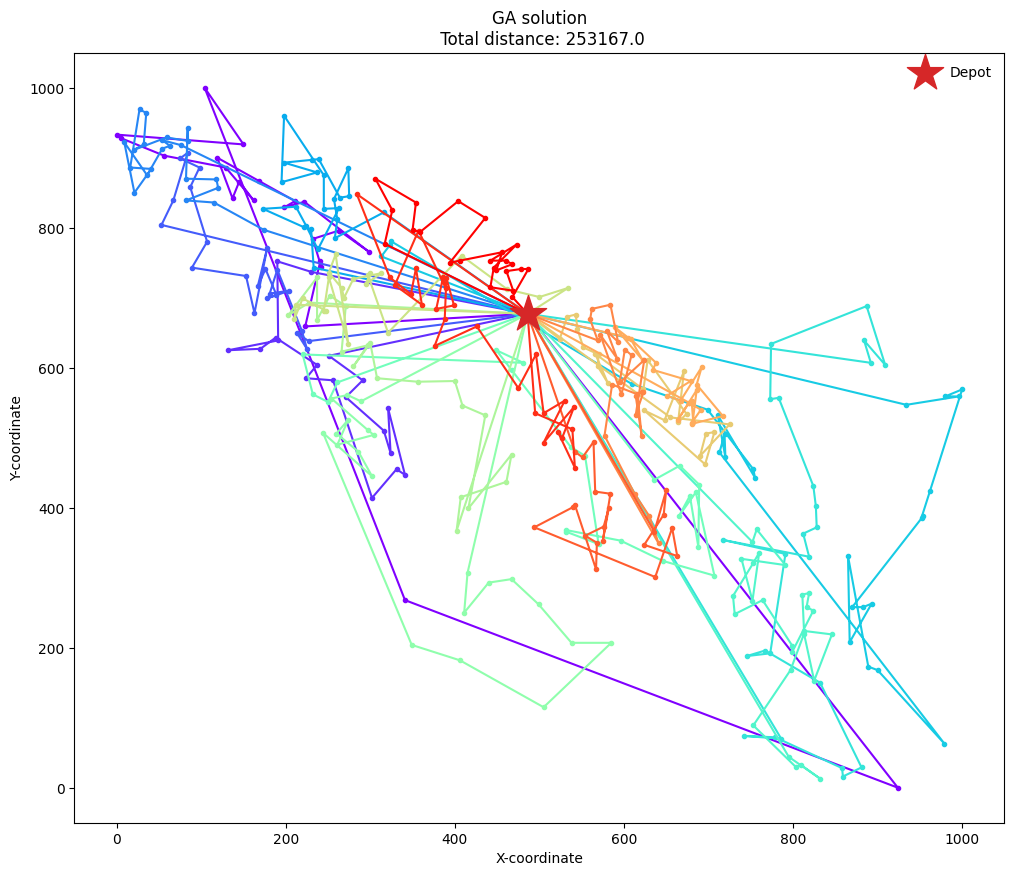

In [13]:
plot_solution(s.bks, "GA solution")

In [14]:
def plot_objective(series):
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.plot(series)


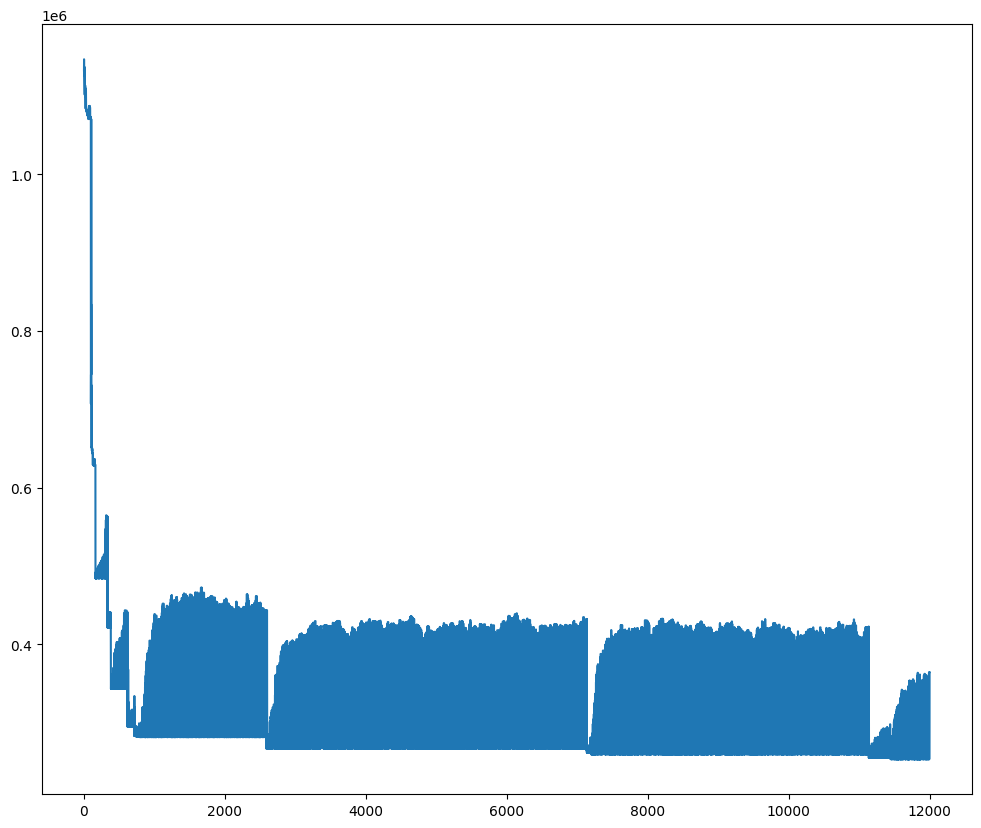

In [15]:
plot_objective([x for x in s.history])